In [1]:
import networkx as nx
import pandas as pd
import numpy as np

In [17]:
training_df = pd.read_csv('data/training_data.csv')
training_df.info()

C:\Users\HP\AppData\Local\Temp\ipykernel_10540\1224424963.py:1: DtypeWarning: Columns (31,38,40) have mixed types. Specify dtype option on import or set low_memory=False.
  training_df = pd.read_csv('data/training_data.csv')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 172848 entries, 0 to 172847
Data columns (total 41 columns):
 #   Column                                         Non-Null Count   Dtype  
---  ------                                         --------------   -----  
 0   general_sector                                 172848 non-null  object 
 1   city                                           171380 non-null  object 
 2   zip_code                                       168919 non-null  float64
 3   specific_sector                                172848 non-null  object 
 4   state                                          172848 non-null  object 
 5   contributor_type                               172848 non-null  object 
 6   winner_ratio                                   172848 non-null  float64
 7   candidacy_count                                172848 non-null  int64  
 8   candidacy_democratic_count                     172848 non-null  int64  
 9   candidacy_republican_count           

In [3]:
winning_bipartite_df = pd.read_csv('data/winning_candidates_state_bipartite_weighted_network.csv')
state_df = pd.read_csv('data/state_contributor_top100_contributors_network.csv', index_col='Unnamed: 0')
fed_df = pd.read_csv('data/federal_contributor_top100_contributors_network.csv', index_col= 'Unnamed: 0')
all_bipartite_df = pd.read_csv('data/all_candidates_state_bipartite_weighted_network.csv')

In [4]:
training_df.head(1)

,general_sector,city,zip_code,specific_sector,state,contributor_type,winner_ratio,candidacy_count,candidacy_democratic_count,candidacy_republican_count,...,governor_contribution_ratio,house_and_assembly_contribution_ratio,politician_challenger_ratio,politician_democratic_ratio,politician_incumbency_ratio,politician_open_pos_ratio,politician_republican_ratio,senate_contribution_ratio,us_house_contribution_ratio,us_senate_contribution_ratio
0,Retired,MISSOULA,59802.0,Retired,MT,Individual,1.0,4,4,0,...,0.5,0.0,0.0,1.0,0.5,0.5,0.0,0.0,0.0,0.0


In [5]:
# uncomment when running for the first time
all_bipartite_df.drop('Unnamed: 1', axis=1, inplace=True)
winning_bipartite_df.drop('Unnamed: 1', axis=1, inplace=True)
all_bipartite_df.rename(columns={'Unnamed: 0':'Name'},  inplace=True)
winning_bipartite_df.rename(columns={'Unnamed: 0':'Name'},   inplace=True)
all_bipartite_df.set_index('Name', inplace=True)
winning_bipartite_df.set_index('Name', inplace=True)

# Extract Features

In [6]:
def create_bipartite_graph(df):
    B = nx.Graph()
    df = df.select_dtypes(include='number')
    
    for index, row in df.iterrows():
        for column in df.columns:
            if row[column] > 0:  # Non-zero contributions
                B.add_edge(index, column, weight=row[column])
    return B

winning_graph = create_bipartite_graph(winning_bipartite_df)
all_candidates_graph = create_bipartite_graph(all_bipartite_df)

# Create graphs for the state and federal contributor networks (adjacency matrices)
state_contributor_graph = nx.from_pandas_adjacency(state_df)
federal_contributor_graph = nx.from_pandas_adjacency(fed_df)

In [7]:
state_contributor_degree = dict(state_contributor_graph.degree())
federal_contributor_degree = dict(federal_contributor_graph.degree())
state_contributor_weighted_degree = {node: sum(weight for _, _, weight in state_contributor_graph.edges(node, data='weight')) for node in state_contributor_graph.nodes()}
federal_contributor_weighted_degree = {node: sum(weight for _, _, weight in federal_contributor_graph.edges(node, data='weight')) for node in federal_contributor_graph.nodes()}
bipartite_degree = {node: winning_graph.degree(node) for node in winning_graph.nodes()}
print("State Contributor Degree:", state_contributor_degree)
print("Federal Contributor Degree:", federal_contributor_degree)
print("Bipartite Degree:", bipartite_degree)

State Contributor Degree: {'MCGUIRE, PERRY J DOUGLASVILLE 30135 GA': 3, 'HANCE, KENT R AUSTIN 78701 TX': 25, 'PHILADELPHIA TRIAL LAWYERS ASSOCIATION PHILADELPHIA 19107 PA': 6, 'STRICKLAND, DEANNA L BROOKLET 30415 GA': 0, 'LAW OFFICES OF PETER G ANGELOS BALTIMORE 21201 VA': 0, 'ELGIN, ROBERT L UNIVERSITY CITY 63130 MO': 7, 'BRISBANE, CHARLES LOCUST VALLEY 11560 NY': 0, 'KRAMER, ORIN S NEW YORK 10022 NY': 51, 'FERNANDEZ, RAUL J RESTON 20191 VA': 12, 'STEFANI, JOHN J CLARKSBURG 8510 NJ': 20, 'LOUISIANA MANUFACTURERS ASSOCIATION BATON ROUGE 70825 LA': 0, 'MURPHY, MARK B ROSWELL 88202 NM': 10, 'ANDREWS & KURTH HOUSTON 77002 TX': 31, 'MEARA, BRIAN R BAYSIDE 11361 NY': 30, 'SANDEL, JERRY W FARMINGTON 87401 NM': 12, 'BALBONI FOR SENATE DIX HILLS 11746 NY': 17, 'BLITZ, ROBERT D FRONTENAC 63131 MO': 5, 'OPPENHEIMER, SUZI MAMARONECK 10543 NY': 8, 'REPUBLICAN ASSEMBLY CAMPAIGN CMTE OF NEW YORK ALBANY 12210 NY': 12, 'CAMDEN COUNTY DEMOCRATIC CENTRAL CMTE OF NEW JERSEY CHERRY HILL 8003 NJ': 12, 'REP

# EDA

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns
import math

In [18]:
# Some ratios are showing as 'object' but probably should be numeric
# Converting that for ease of numeric cols analysis.

cols_to_convert = ['governor_contribution_ratio', 'senate_contribution_ratio', 'us_senate_contribution_ratio']
for col in cols_to_convert:
    # Try converting, coercing errors to NaN
    training_df[col] = pd.to_numeric(training_df[col], errors='coerce')

In [29]:
# checking for missing values
missing_summary = training_df.isnull().sum().sort_values(ascending=False)
missing_percent = (missing_summary / len(training_df)) * 100

missing_df = pd.DataFrame({
    'Missing Values': missing_summary,
    'Percentage (%)': missing_percent
})

#print(missing_df[missing_df['Missing Values'] > 0])

In [20]:
#                                      Missing Values  Percentage (%)
#zip_code                                         3929        2.273095
#city                                             1468        0.849301
#senate_contribution_ratio                         193        0.111659
#governor_contribution_ratio                       193        0.111659
#us_senate_contribution_ratio                      193        0.111659
#us_house_contribution_ratio                       192        0.111080
#house_and_assembly_contribution_ratio             192        0.111080

In [21]:
# dropping the missing values of ratio cols since its a really small number?
training_df.dropna(subset=[
        'senate_contribution_ratio', 'governor_contribution_ratio',
        'us_senate_contribution_ratio', 'us_house_contribution_ratio',
        'house_and_assembly_contribution_ratio'\
    ], inplace=True)


In [27]:
# filling city with 'Unknown' & zipcode with 0

training_df['city'] = training_df['city'].fillna('Unknown')
training_df['zip_code'] = training_df['zip_code'].fillna("00000")


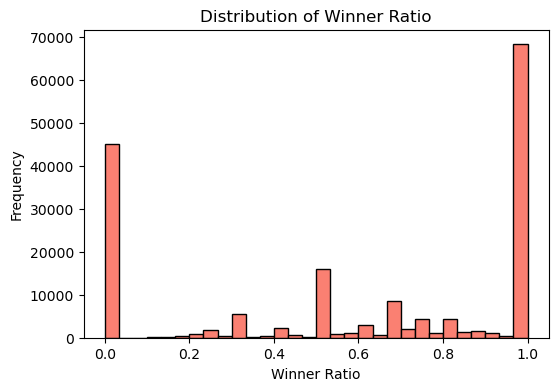

In [38]:
# looking at target variabke

#histogram
plt.figure(figsize=(6, 4))  
plt.hist(training_df['winner_ratio'], bins=30, color='salmon', edgecolor='black')
plt.title('Distribution of Winner Ratio')
plt.xlabel('Winner Ratio')
plt.ylabel('Frequency')
plt.show()

Bimodal distribution. I'm thinking this distribution suggests that contributors might be influenced by their networks. 

In [ ]:
# features to look at 
num_features = training_df.select_dtypes(include=np.number).columns.drop('winner_ratio')
cat_features = training_df.select_dtypes(include='object').columns

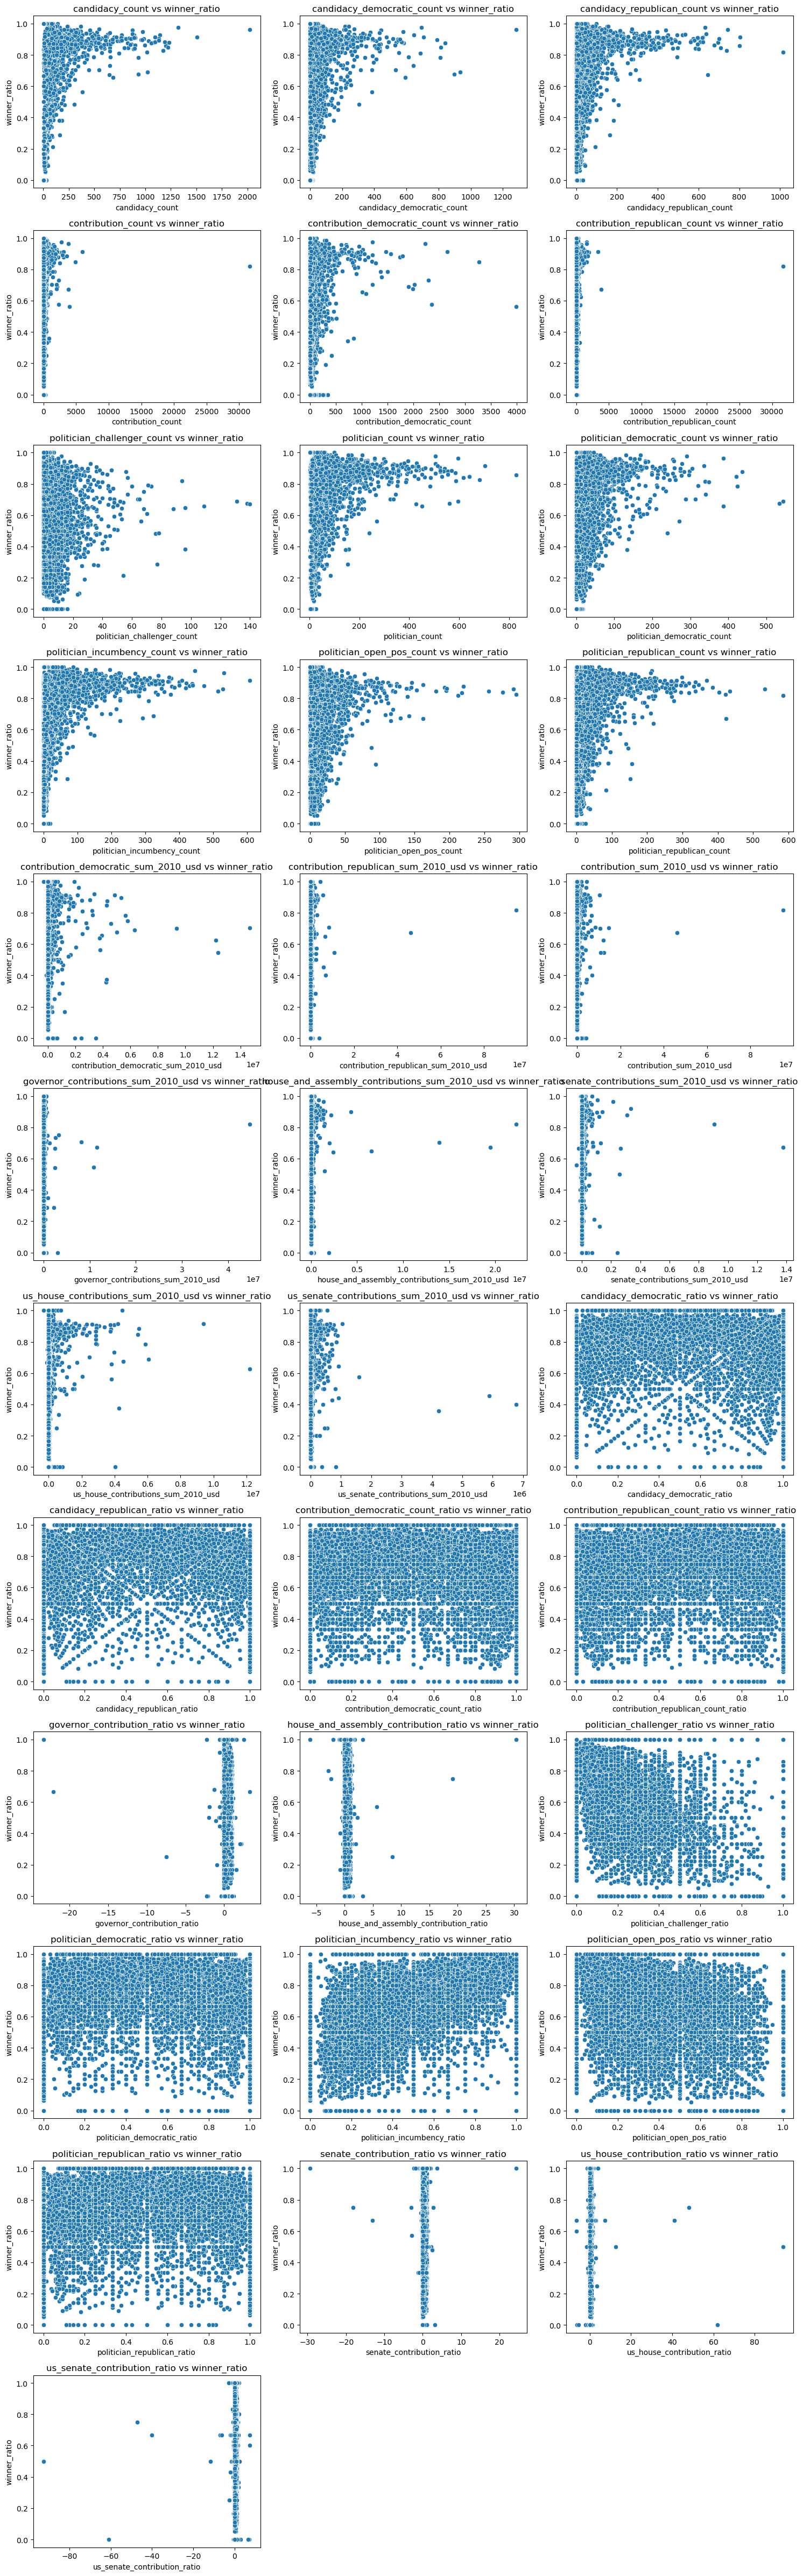

In [45]:
cols = 3
rows = math.ceil(len(num_features) / cols)

fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 4 * rows))
axes = axes.flatten()  # flatten to make indexing easier

for i, feature in enumerate(num_features):
    sns.scatterplot(x=training_df[feature], y=training_df['winner_ratio'], ax=axes[i])
    axes[i].set_title(f'{feature} vs winner_ratio')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('winner_ratio')

# Turn off unused subplots if any
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()